# Stimulating AI-Driven Mental Health Guidance with NLP

## Research Ideas
- Creating sentence-matching algorithms for natural language processing to accurately match given questions with appropriate advice and guidance.
- Analyzing the psychological conversations to gain insights into topics such as stress, anxiety, and depression.
- Developing personalized natural language processing models tailored to provide users with appropriate advice based on their queries and based on their individual state of mental health

In [1]:
import pandas as pd
import re

In [2]:
data = pd.read_csv("C:/Users/ikry/OneDrive/Desktop/MSc DS/PROJECTS/mental_health_conversations.csv")

In [3]:
# preprocessing text data
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.strip()

data['Context_Clean'] = data['Context'].apply(preprocess_text)
data['Response_Clean'] = data['Response'].apply(preprocess_text)

## Emotion Detection

### Here are a few popular pre-trained models for emotion detection:

DistilBERT-based Models:
bhadresh-savani/distilbert-base-uncased-emotion
nlptown/bert-base-multilingual-uncased-sentiment

BERT-based Models:
nlptown/bert-base-multilingual-uncased-sentiment

RoBERTa-based Models:
textattack/roberta-base-SST-2

XLNet-based Models:
textattack/xlnet-base-cased-SST-2

In [27]:
from transformers import pipeline
from sklearn.pipeline import Pipeline
import tensorflow as tf

# Load the emotion detection model with the tokenizer
emotion_detector = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion")
#Create a pipeline for emotion detection using a pre-trained model. The specified model is "bhadresh-savani/distilbert-base-uncased-emotion," which appears to be a custom model trained for emotion detection based on the DistilBERT architecture. The top_k parameter is set to None, indicating that all predictions should be returned.

#tasks available for pipeline are ['audio-classification', 'automatic-speech-recognition', 'feature-extraction', 'text-classification', 'token-classification', 'question-answering', 'table-question-answering', 'fill-mask', 'summarization', 'translation', 'text2text-generation', 'text-generation', 'zero-shot-classification', 'conversational', 'image-classification', 'object-detection', 'translation_XX_to_YY']

# Function to detect emotions with text truncation
def detect_emotion(text):
    try:
        # Pass the raw text directly to the emotion detector
        return emotion_detector(text, truncation=True)
    except Exception as e:
        print(f"Error during emotion detection: {e}")
        return None
    
sample_text = data['Context_Clean'].iloc[0]
print("Sample text:", sample_text)

detected_emotions = detect_emotion(sample_text)

print("Detected emotions:", detected_emotions)

Sample text: im going through some things with my feelings and myself i barely sleep and i do nothing but think about how im worthless and how i shouldnt be here ive never tried or contemplated suicide ive always wanted to fix my issues but i never get around to it how can i change my feeling of being worthless to everyone
Detected emotions: [{'label': 'sadness', 'score': 0.9985948204994202}]


## Apply emotion detection to the whole dataset

In [30]:
import numpy as np
from tqdm import tqdm

def get_dominant_emotion(emotion_output):
    if emotion_output and isinstance(emotion_output, list):
        emotions = emotion_output
        if emotions:
            return sorted(emotions, key=lambda x: x.get('score', 0), reverse=True)[0].get('label', None)
    return None

def detect_emotion(text):
    try:
        # Pass the raw text directly to the emotion detector
        emotion_result = emotion_detector(text, truncation=True)[0]  
        return emotion_result
    except Exception as e:
        print(f"Error during emotion detection: {e}")
        return None

def process_in_batches(texts, batch_size=32):
    emotions = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i + batch_size]
        batch_emotions = [detect_emotion(text) for text in batch_texts]
        dominant_emotions = [get_dominant_emotion(e) for e in batch_emotions]
        emotions.extend(dominant_emotions)
    return emotions

# Apply the function to the Context and Response columns
batch_size = 32  
data['Context_Emotion'] = process_in_batches(data['Context_Clean'].tolist(), batch_size=batch_size)
data['Response_Emotion'] = process_in_batches(data['Response_Clean'].tolist(), batch_size=batch_size)


Processing batches: 100%|██████████| 110/110 [06:10<00:00,  3.37s/it]


In [32]:
def process_in_batches(texts, batch_size=32):
    emotions = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i + batch_size]
        batch_emotions = [detect_emotion(text) for text in batch_texts]

        # Filter out empty results
        batch_emotions = [e for e in batch_emotions if e is not None]

        dominant_emotions = [get_dominant_emotion(e) for e in batch_emotions]
        emotions.extend(dominant_emotions)
    return emotions

# Apply the function to the Context and Response columns
batch_size = 32  
data['Context_Emotion'] = process_in_batches(data['Context_Clean'].tolist(), batch_size=batch_size)
data['Response_Emotion'] = process_in_batches(data['Response_Clean'].tolist(), batch_size=batch_size)

Processing batches: 100%|██████████| 110/110 [11:38<00:00,  6.35s/it]


## Analyzing Emotion Patterns

In [33]:
context_emotion_counts = data['Context_Emotion'].value_counts()
response_emotion_counts = data['Response_Emotion'].value_counts()

print("Context Emotion Counts:\n", context_emotion_counts)
print("\nResponse Emotion Counts:\n", response_emotion_counts)
#why there are no emotions to count???

Context Emotion Counts:
 Series([], Name: count, dtype: int64)

Response Emotion Counts:
 Series([], Name: count, dtype: int64)


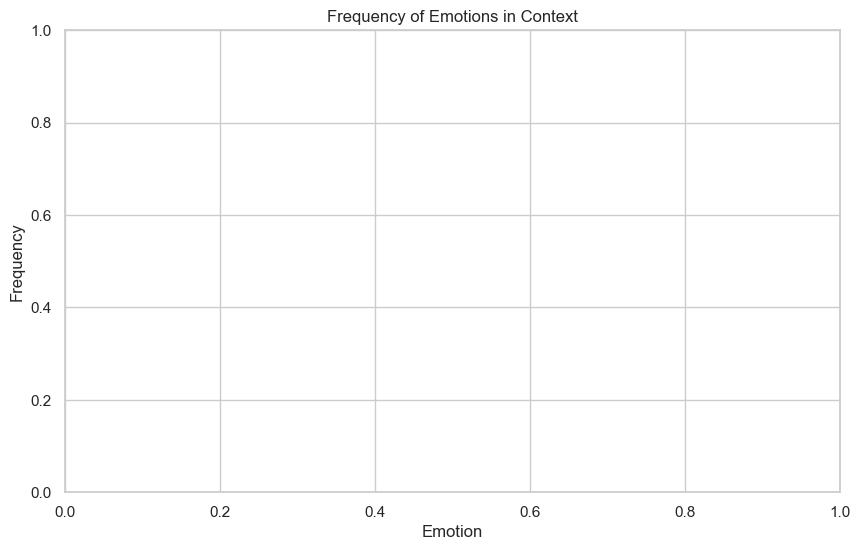

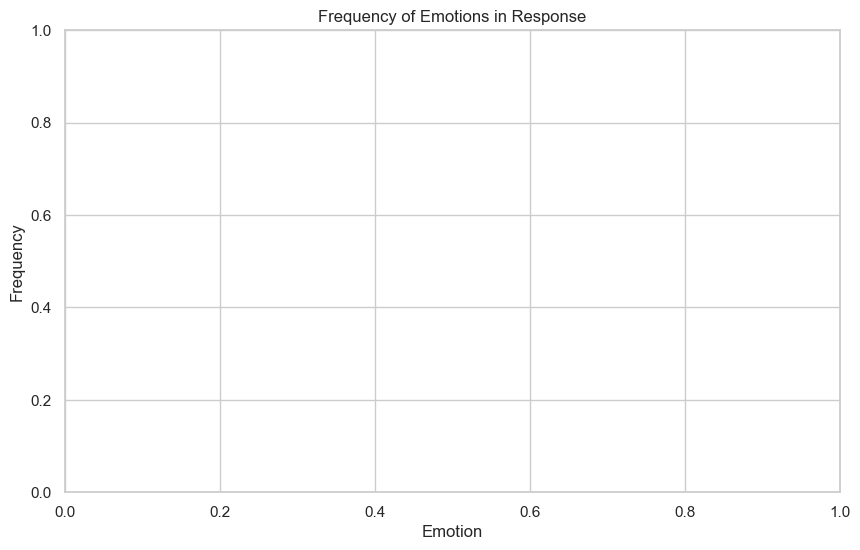

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Plotting Context Emotion Counts
plt.figure(figsize=(10, 6))
sns.barplot(x=context_emotion_counts.index, y=context_emotion_counts.values)
plt.title('Frequency of Emotions in Context')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

# Plotting Response Emotion Counts
plt.figure(figsize=(10, 6))
sns.barplot(x=response_emotion_counts.index, y=response_emotion_counts.values)
plt.title('Frequency of Emotions in Response')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

In [22]:
# Create a DataFrame for emotion transitions
emotion_transitions = pd.crosstab(data['Context_Emotion'], data['Response_Emotion'])

plt.figure(figsize=(10, 8))
sns.heatmap(emotion_transitions, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Heatmap of Emotion Transitions from Context to Response')
plt.xlabel('Response Emotion')
plt.ylabel('Context Emotion')
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1000x800 with 0 Axes>

In [23]:
from wordcloud import WordCloud

# Function to generate word clouds for each emotion
def generate_word_clouds(data, column):
    emotions = data[column].unique()
    for emotion in emotions:
        subset = data[data[column] == emotion]
        text = " ".join(review for review in subset.Context_Clean)
        wordcloud = WordCloud(background_color="white").generate(text)

        # Display the generated image
        plt.figure(figsize=(10,6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Word Cloud for {emotion}")
        plt.axis("off")
        plt.show()

generate_word_clouds(data, 'Context_Emotion')

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [ ]:
# Comparative bar chart
emotion_categories = data['Context_Emotion'].unique()
context_counts = data['Context_Emotion'].value_counts()
response_counts = data['Response_Emotion'].value_counts()

# Create a DataFrame for easy plotting
emotion_comparison = pd.DataFrame({
    'Context': context_counts,
    'Response': response_counts
}).reindex(emotion_categories).fillna(0)

emotion_comparison.plot(kind='bar', figsize=(12, 6))
plt.title('Comparative Emotion Counts in Context vs. Response')
plt.xlabel('Emotion')
plt.ylabel('Counts')
plt.show()

In [ ]:
import networkx as nx

# Create a graph from the emotion transitions DataFrame
G = nx.from_pandas_adjacency(emotion_transitions)

# Plot the network graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=7)  # for consistent layout
nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', linewidths=1, font_size=15)
plt.title('Network Graph of Emotion Transitions')
plt.show()